Этот набор данных содержит информацию о различных свойствах набора фруктов, позволяющую получить представление об их характеристиках. Набор данных включает такие сведения, как идентификатор плода, размер, вес, сладость, хрусткость, сочность, зрелость, кислотность и качество.

Цель - разработать модель для прогназирования качества плодов

План работы
1. Предобработка данных
    - Импортируеем и изучаем данные
    - пропуски, аномалии
    - изучение признаков
2. Обучение моделей.
    - подбор гипперпараметров
    - выбор лучшей модели
    - Кроссвалидация лучшей модели

In [ ]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.model_selection import learning_curve


import warnings
warnings.filterwarnings ('ignore')

sns.set(style="whitegrid")
# модули для обучения модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

1.Импорт данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/apple_quality.csv')#вставили путь

Вывежем первые и последние 5 строк датасета

In [ ]:
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [ ]:
df.tail()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796456,good
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


- index: индекс датафрейма
- A_id: номер объекта в датафрейме (совпадает с index)
- Size: Размер элемента в некоторой единице измерения.
- Weight: Вес элемента в некоторой единице измерения.
- Sweetness: степень сладости продукта по шкале от очень сладкого до очень кислого.
- Crunchiness: степень хрусткости продукта по шкале от очень мягкого до очень хрустящего.
- Juiciness: степень сочности продукта по шкале от очень сухого до очень сочного.
- Ripeness: степень спелости продукта по шкале от незрелого до перезрелого.
- Acidity: уровень кислотности продукта по шкале от очень низкого до очень высокого.
- Quality: общая оценка качества продукта, либо "good" либо "bad" (хорошо/плохо). - Это Целевой Признак объекта (таргет)

В датасете 4001 записей из них 4000 - описывают объекты.
Последняя запись в таблице хранит информацию о Создателе датасета (Created_by_Nidula_Elgiriyewithana)

Удалим эту запись а после изучим датасет используя команды info и describe

In [ ]:
df=df[:-1]

In [ ]:
df.tail()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
3995,3995.0,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784369,bad
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796456,good


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


In [ ]:
df.describe()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


Все признаки кроме Acidity и Quality имеют тип данных float64.

Acidity и Quality имеют тип данных -  object.
Приведем эти признаки к численному типу данных.

Acidity - приведем к типу float64.
Для Quality - напишем функцию которая заменит значения "good" и "bad" на 1 и 0 соответственно.

 Удалим признак A_id- поскольку он не описывает качество объекта.

In [ ]:
def clean_data(df):

    df = df.drop(columns=['A_id'])

    df = df.dropna()

    df = df.astype({'Acidity': 'float64'})

    def label(Quality):
        if Quality == "good":
            return 0

        if Quality == "bad":
            return 1

        return None

    df['Label'] = df['Quality'].apply(label)

    df = df.drop(columns=['Quality'])

    df = df.astype({'Label': 'int64'})

    return df

df_clean = clean_data(df.copy())
df_clean.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Label
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,0
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,0
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,1
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,0
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,0


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   float64
 7   Label        4000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 250.1 KB


In [ ]:
df_clean.describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Label
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,0.076877,0.499000
std,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,2.110270,0.500062
min,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538,0.000000
25%,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424,0.000000
50%,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609,0.000000
75%,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493,1.000000
max,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736,1.000000


В столбце Label храниться информация о качестве плодов - это будет целевой признак для модели. Из инфрмации о датасете можно сделать вывод, что примерно половина плодов хорошего качества, а половина плохого.
Все остальные признаки описывают объект в некоторых еденицах исчисления и оценить верность данных не возможно. Стоит отметить, что половина данных в признаках Size, Weight, Sweetness - имеют отрицательны значения.

Построим график распределения признаков и матрицу коллеряции

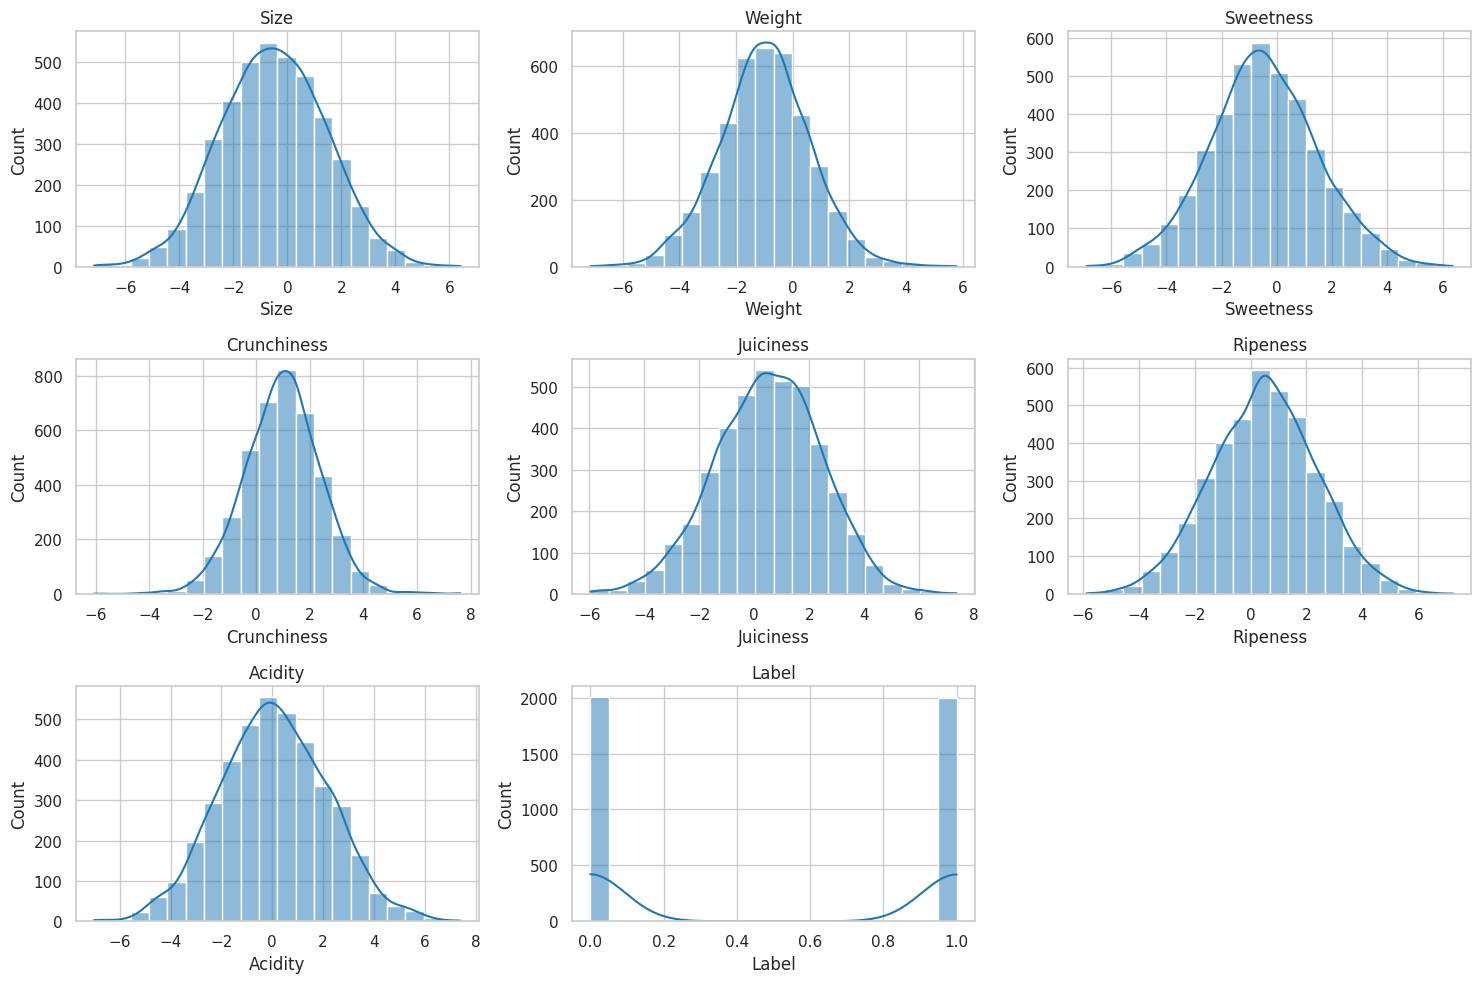

In [ ]:
numerical_cols = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity', 'Label']

plt.figure(figsize=(15, 10))
sns.set_palette("tab10")

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_clean, x=column, kde=True, bins=20)
    plt.title(column)

plt.tight_layout()
plt.show()

Признаки имеют нормальное распределение

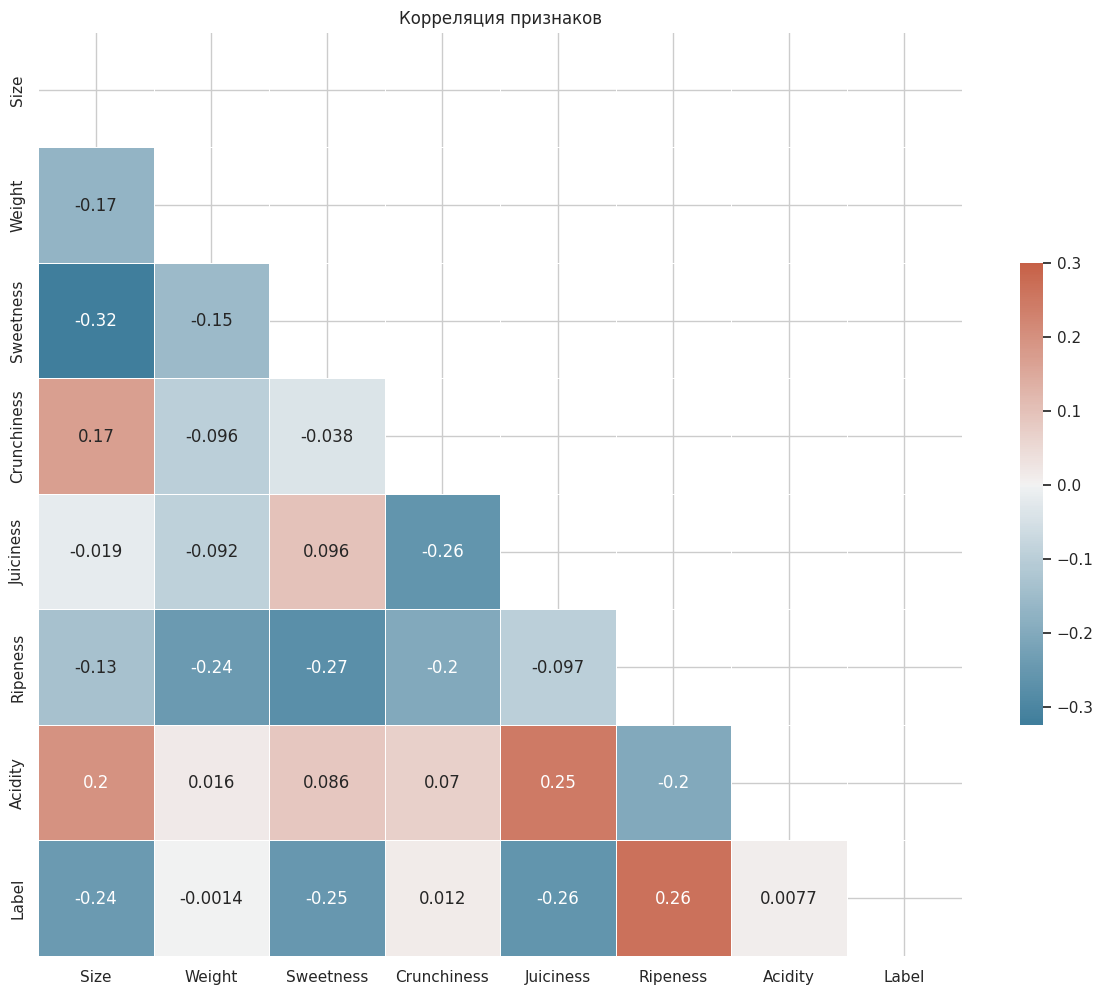

In [ ]:
corr = df_clean.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(15, 12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Корреляция признаков')
plt.show()

Между признаками наблюдается слабая (положительная и отрицательная) корреляция от 0 до 0,3. У ряда признаков средняя корреляция от 0,3

Проведем нормализацию данных

In [ ]:
df1 = df_clean.copy()

In [ ]:
X = df1.drop(['Label'], axis=1)
y = df1['Label']

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [ ]:
X_resampled.describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
count,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000
mean,0.490431,0.476027,0.483921,0.514861,0.485754,0.485673,0.491819
std,0.142145,0.123774,0.146609,0.102545,0.144913,0.143085,0.146420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.393548,0.397052,0.388526,0.447492,0.387234,0.388877,0.390824
50%,0.489598,0.476383,0.481469,0.515914,0.487180,0.486020,0.487914
75%,0.586959,0.554808,0.579613,0.581305,0.585042,0.582625,0.591137
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Обучение модели

Разделим данные на тестовую и обучающую выборку

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Обучим следующие модели
- Random Forest Classifier
- LGBM Classifier
- Метод опорных векторов (SVC)

#Random Forest Classifier

In [ ]:
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

rf = RandomForestClassifier()

randomized_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_rf.fit(X_train, y_train)

best_params_rf = randomized_search_rf.best_params_
print(f"Лучшие гипперпараметры для Random Forest: {best_params_rf}")

best_rf_model = randomized_search_rf.best_estimator_

rf_predicted = best_rf_model.predict(X_test)

rf_acc_score = accuracy_score(y_test, rf_predicted)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)

print("\nТочность Random Forest Classifier:", rf_acc_score * 100, '\n')
print("Отчет о классификации - Random Forest:")
print(classification_report(y_test, rf_predicted))

Лучшие гипперпараметры для Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': True}

Точность Random Forest Classifier: 89.77556109725685 

Отчет о классификации - Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       412
           1       0.89      0.89      0.89       390

    accuracy                           0.90       802
   macro avg       0.90      0.90      0.90       802
weighted avg       0.90      0.90      0.90       802



#LGBM Classifier

In [ ]:
param_dist_lgbm = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, -1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

lgbm = LGBMClassifier()

randomized_search_lgbm = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_lgbm.fit(X_train, y_train)

best_params_lgbm = randomized_search_lgbm.best_params_
print(f"ЛУчшие гипперпараметры LGBMClassifier: {best_params_lgbm}")

best_lgbm_model = randomized_search_lgbm.best_estimator_

lgbm_predicted = best_lgbm_model.predict(X_test)

lgbm_acc_score = accuracy_score(y_test, lgbm_predicted)
lgbm_conf_matrix = confusion_matrix(y_test, lgbm_predicted)

print("\nТочность LGBMClassifier:", lgbm_acc_score * 100, '\n')
print("Отчет о классификации -  LGBMClassifier:")
print(classification_report(y_test, lgbm_predicted))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1614, number of negative: 1592
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3206, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503431 -> initscore=0.013724
[LightGBM] [Info] Start training from score 0.013724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

#Метод опорных векторов (SVC)

In [ ]:
param_dist = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
}

svc = SVC()

randomized_search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

randomized_search.fit(X_train, y_train)

best_params = randomized_search.best_params_
print(f"Лучшие гипперпараметры: {best_params}")

best_svc_model = randomized_search.best_estimator_
svc_predicted = best_svc_model.predict(X_test)

svc_acc_score = accuracy_score(y_test, svc_predicted)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)


print("\nТочность метода опорных векторов:", svc_acc_score * 100, '\n')
print("Отчет о классификации SVC:")
print(classification_report(y_test, svc_predicted))

Лучшие гипперпараметры: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}

Точность метода опорных векторов: 91.52119700748129 

Отчет о классификации SVC:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       412
           1       0.90      0.93      0.91       390

    accuracy                           0.92       802
   macro avg       0.92      0.92      0.92       802
weighted avg       0.92      0.92      0.92       802



- Точность Random Forest Classifier: 88.5286783042394
- Точность LGBMClassifier: 89.77556109725685
- Точность метода опорных векторов: 91.52119700748129

Лучшая точность у метода опорных векторов (SVC)
Эту модель и выберим для

# Кросс валидаци

Модель SVC выберем для кросс-валидации (перекресная проверка)

In [ ]:
cross_val_scores = cross_val_score(best_svc_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print("\nРезультат проверки на кросс-валидации :")
print(cross_val_scores)

average_cv_score = cross_val_scores.mean()
print("\nСредний балл на кросс-валидации:", average_cv_score * 100)


Результат проверки на кросс-валидации :
[0.90031153 0.89859594 0.92043682 0.90483619 0.90639626]

Средний балл на кросс-валидации: 90.6115347417635


# Выводы


Изучен и обработан датасет хранящий в себе информацию о спелости плодов содержащий следующие признаки
Size: Размер элемента в некоторой единице измерения.
Weight: Вес элемента в некоторой единице измерения.
Sweetness: степень сладости продукта по шкале от очень сладкого до очень кислого.
Crunchiness: степень хрусткости продукта по шкале от очень мягкого до очень хрустящего.
Juiciness: степень сочности продукта по шкале от очень сухого до очень сочного.
Ripeness: степень спелости продукта по шкале от незрелого до перезрелого.
Acidity: уровень кислотности продукта по шкале от очень низкого до очень высокого.
Quality: общая оценка качества продукта, либо "good" либо "bad" (хорошо/плохо).
В качествен целевого признака был выбран - Quality.

После изучения датасета было произведено изменение типов данных двух признаков (Acidity и  Quality).
Построены графики распределения и матрица корреляции признаков.
для обучения было выбрано 3 модели
- Random Forest Classifier
- LGBM Classifier
- Метод опорных векторов (SVC)
Из которых модель SVC показала лучший результат на этапе обучения (точность 91.5) и была выбрана для проверки на кроссвалидации и показала следующие результаты точности на тестовой выборке - 90.6

